In [18]:
import sys
sys.path.append('../')
import mvcomp as mvc

import os
from os.path import join, basename

import glob
import matplotlib.pyplot as plt
import numpy as np

# Define the path to subject directory

In [2]:
# indicate what is the subject path where all the feature images are located
# we will use the data in local_extras (check example 1 for more details on how to obtain it)
_subject_path = "../local_extras/sample_MRI/001/"
P_folders = glob.glob(join(_subject_path,'*nii.gz'))

In [3]:
print(f"We have 3 features for this subject, they are {P_folders}")

We have 3 features for this subject, they are ['../local_extras/sample_MRI/001/T1map.nii.gz', '../local_extras/sample_MRI/001/inv2.nii.gz', '../local_extras/sample_MRI/001/T1w.nii.gz']


# Computing D2

In [12]:
result_D2 = mvc.voxel2voxel_dist(subdir= _subject_path,suffix_name_comp = ".nii.gz",mask_f="../local_extras/sample_MRI/mask.nii.gz",
                                 feat_sub=["T1map"]) 
# do not run with all the features, it need 161 TiB of memory
# manipulate the mask theshold to reduce the number of voxels and make it feasible to run

print(result_D2.shape) # Shape will be (number of voxels) x (number of voxels)

# Save matrix containing all D2 data as a numpy array

# np.save('/project/Analyses/D2_sub007_voxvox_subjects.npy', result_D2)

Features are :  ['T1w', 'inv2']
(7, 7)


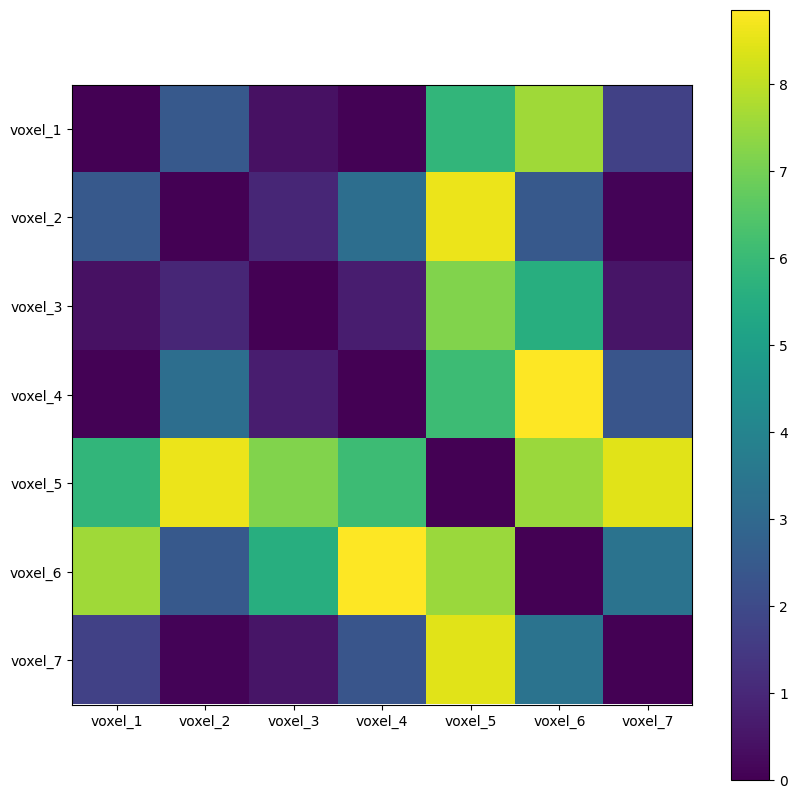

In [25]:
fig = plt.figure(figsize=(10,10))
plt.imshow(result_D2)
vxl_id = [f"voxel_{idx}" for idx in range(1,1+result_D2.shape[0])]
plt.xticks(np.arange(0,result_D2.shape[0]), vxl_id)
plt.yticks(np.arange(0,result_D2.shape[0]), vxl_id)

plt.colorbar()
plt.show()
